<a href="https://colab.research.google.com/github/Venchislav/Neural-Networks/blob/main/CatsVsDogsKaggle(Cool_And_New).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:38<00:00, 22.0MB/s]
100% 812M/812M [00:38<00:00, 21.9MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

In [6]:
import os, shutil, pathlib

In [7]:
original_dir = pathlib.Path('train')
new_dir = pathlib.Path('cats_vs_dogs_smaller')

In [8]:
def make_subset(subset_name, start_indx, end_indx):
  for category in ('cat', 'dog'):
    dir = new_dir / subset_name / category
    os.makedirs(dir)
    filenames = [f'{category}.{i}.jpg' for i in range(start_indx, end_indx)]
    for filename in filenames:
      shutil.copyfile(src=original_dir / filename, dst=dir / filename)

In [9]:
make_subset('train', start_indx=0, end_indx=1000)
make_subset('validation', start_indx=1000, end_indx=1500)
make_subset('test', start_indx=1500, end_indx=2500)

In [10]:
os.listdir('train')[:5]

['cat.9030.jpg', 'dog.3814.jpg', 'dog.3673.jpg', 'dog.9492.jpg', 'dog.138.jpg']

# **MODEL BUILDING**

In [11]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [12]:
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)

x = layers.Flatten()(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

In [13]:
model = keras.Model(inputs, outputs)

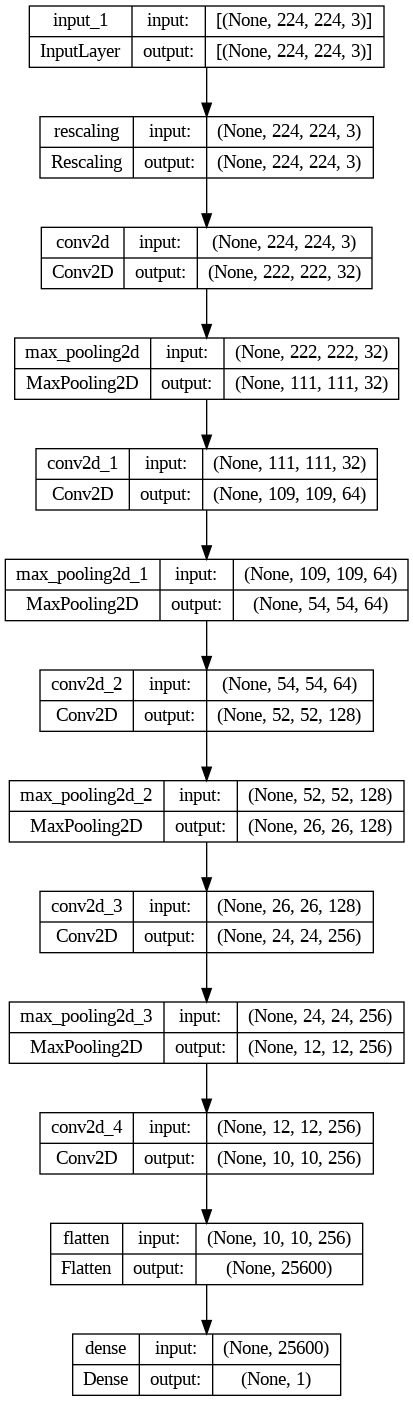

In [14]:
keras.utils.plot_model(model, show_shapes=True)

In [15]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# **DATA PREPROCESSING**

In [16]:
from tensorflow.keras.utils import image_dataset_from_directory

In [17]:
train_dataset = image_dataset_from_directory(
    new_dir / 'train',
    image_size=(224, 224),
    shuffle=True,
    batch_size=32
)

val_dataset = image_dataset_from_directory(
    new_dir / 'validation',
    image_size=(224, 224),
    shuffle=True,
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_dir / 'test',
    image_size=(224, 224),
    shuffle=True,
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [18]:
import matplotlib.pyplot as plt

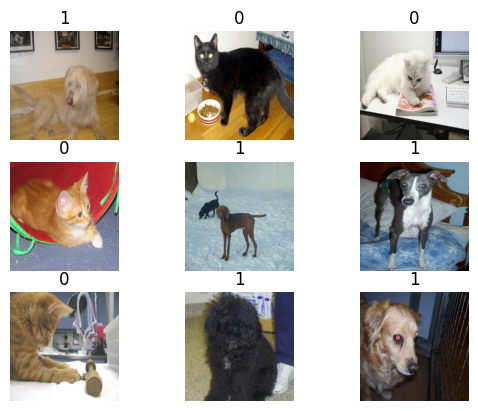

In [19]:
for img, lbl in train_dataset.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.axis('off')
    plt.title(str(int(lbl[i])))
    plt.imshow(np.array(img[i]).astype('uint8'));

# In Keras Datasets are simply an iterators<br>
(it's easy, but I just have to keep it in my mind)

# **FITTING**

In [20]:
callbacks = [
    keras.callbacks.EarlyStopping(min_delta=0.001, patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('weights', save_best_only=True, monitor='val_loss')
]

In [21]:
hist = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 [==============================] - 16s 142ms/step - loss: 0.6921 - accuracy: 0.5265 - val_loss: 0.6785 - val_accuracy: 0.5420
Epoch 2/30
63/63 [==============================] - 7s 100ms/step - loss: 0.6583 - accuracy: 0.6190 - val_loss: 0.6705 - val_accuracy: 0.6020
Epoch 3/30
63/63 [==============================] - 7s 109ms/step - loss: 0.6114 - accuracy: 0.6700 - val_loss: 0.6208 - val_accuracy: 0.6520
Epoch 4/30
63/63 [==============================] - 6s 96ms/step - loss: 0.5751 - accuracy: 0.7170 - val_loss: 0.5849 - val_accuracy: 0.6940
Epoch 5/30
63/63 [==============================] - 6s 94ms/step - loss: 0.5586 - accuracy: 0.7190 - val_loss: 0.5921 - val_accuracy: 0.6760
Epoch 6/30
63/63 [==============================] - 6s 95ms/step - loss: 0.5052 - accuracy: 0.7630 - val_loss: 0.5723 - val_accuracy: 0.6950
Epoch 7/30
63/63 [==============================] - 7s 112ms/step - loss: 0.4927 - accuracy: 0.7620 - val_loss: 0.5525 - val_accuracy: 0.7340
Epoch 8/

In [22]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

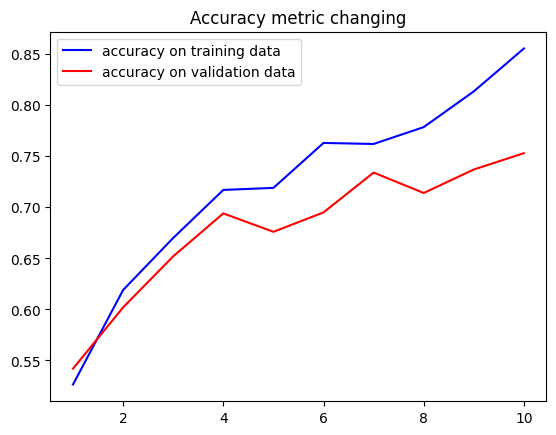

In [23]:
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'b', label='accuracy on training data')
plt.plot(epochs, val_accuracy, 'r', label='accuracy on validation data')
plt.title('Accuracy metric changing')
plt.legend()
plt.show()

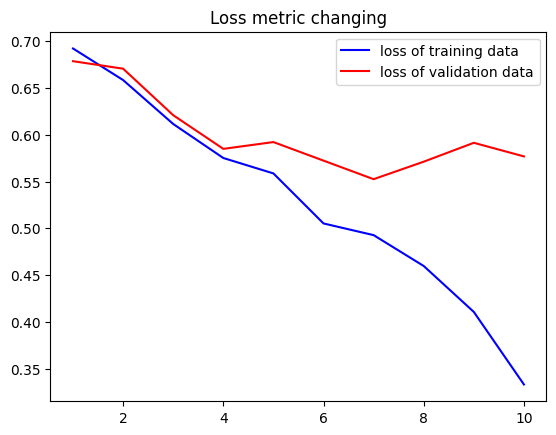

In [24]:
plt.plot(epochs, loss, 'b', label='loss of training data')
plt.plot(epochs, val_loss, 'r', label='loss of validation data')
plt.title('Loss metric changing')
plt.legend()
plt.show()

In [25]:
test_loss, test_accuracy = model.evaluate(test_dataset)

63/63 [==============================] - 4s 47ms/step - loss: 0.5749 - accuracy: 0.7180


# **I 💚 CODING**

# **APPLY DATA AUGMENTATION**

In [26]:
# we can do it with keras model

In [27]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

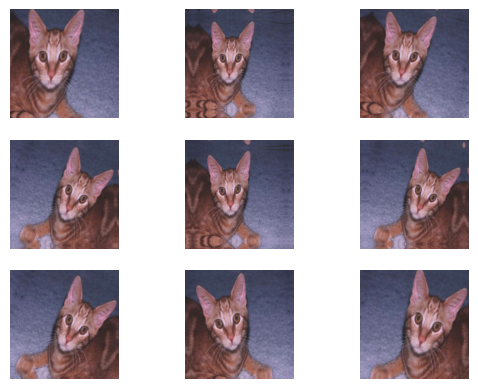

In [30]:
for imgs, _ in train_dataset.take(1):
  for i in range(9):
    augmented_imgs = data_augmentation(imgs)
    plt.subplot(3, 3, i + 1)
    plt.axis('off')
    plt.imshow(np.array(augmented_imgs[0]).astype('uint8'))

Yo yo kitty

In [42]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

In [43]:
model = keras.Model(inputs, outputs)

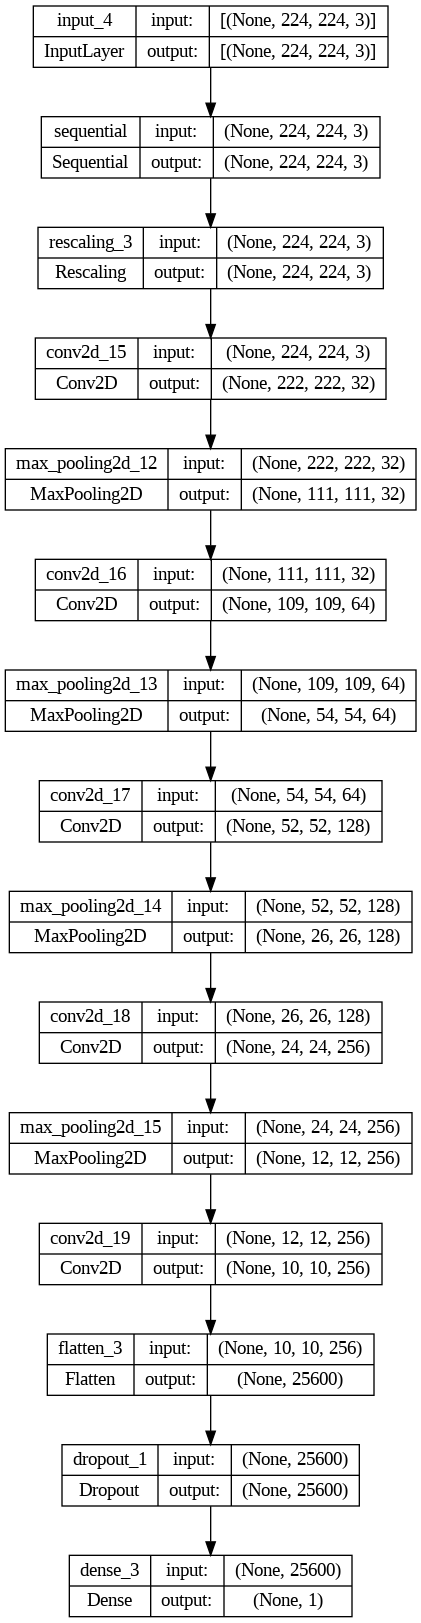

In [44]:
keras.utils.plot_model(model, show_shapes=True)

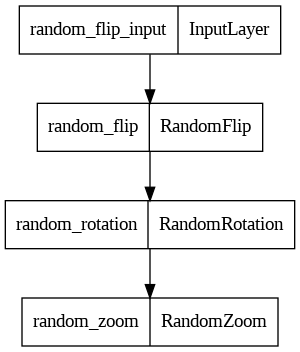

In [45]:
keras.utils.plot_model(data_augmentation)

In [46]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [47]:
hist = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset
)

Epoch 1/30
63/63 [==============================] - 9s 110ms/step - loss: 0.7015 - accuracy: 0.4985 - val_loss: 0.6929 - val_accuracy: 0.5560
Epoch 2/30
63/63 [==============================] - 5s 81ms/step - loss: 0.6933 - accuracy: 0.5195 - val_loss: 0.6906 - val_accuracy: 0.5930
Epoch 3/30
63/63 [==============================] - 6s 98ms/step - loss: 0.6885 - accuracy: 0.5250 - val_loss: 0.6873 - val_accuracy: 0.5120
Epoch 4/30
63/63 [==============================] - 5s 81ms/step - loss: 0.6943 - accuracy: 0.4980 - val_loss: 0.6856 - val_accuracy: 0.5000
Epoch 5/30
63/63 [==============================] - 7s 99ms/step - loss: 0.6837 - accuracy: 0.5490 - val_loss: 0.6616 - val_accuracy: 0.5840
Epoch 6/30
63/63 [==============================] - 5s 81ms/step - loss: 0.6570 - accuracy: 0.6155 - val_loss: 0.6422 - val_accuracy: 0.6320
Epoch 7/30
63/63 [==============================] - 6s 84ms/step - loss: 0.6482 - accuracy: 0.6305 - val_loss: 0.6273 - val_accuracy: 0.6410
Epoch 8/30
6

In [48]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

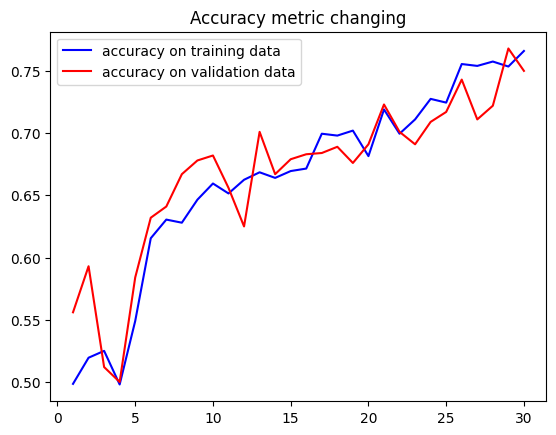

In [49]:
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'b', label='accuracy on training data')
plt.plot(epochs, val_accuracy, 'r', label='accuracy on validation data')
plt.title('Accuracy metric changing')
plt.legend()
plt.show()

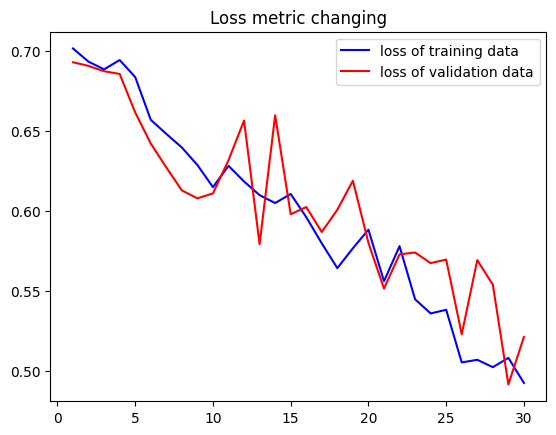

In [50]:
plt.plot(epochs, loss, 'b', label='loss of training data')
plt.plot(epochs, val_loss, 'r', label='loss of validation data')
plt.title('Loss metric changing')
plt.legend()
plt.show()

In [51]:
test_loss, test_accuracy = model.evaluate(test_dataset)

63/63 [==============================] - 3s 39ms/step - loss: 0.5457 - accuracy: 0.7420
